In [1]:
############
# Imports #

import torch
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import rasterio
import numpy as np
from torchvision import models, transforms
from utils import ImageDataset, SaveFeatures, accuracy, imshow_transform
from custom_model import model_4D
from torch.autograd import Variable
from skimage.transform import resize
from skimage.io import imshow
import wandb
import matplotlib.pyplot as plt 

%matplotlib inline


###################
# Hyperparameters #

n_samples = 25
n_samples_train = 5
# n_samples_train = int(round(n_samples*0.8))
batch_size = 5
current_computer =  "macbook" # "ubuntu"
layers_to_freeze = 41
lr = 0.00001
weight_decay=0.09
num_epochs = 4
im_size = 100
min_palsa_positive_samples = 0


##########################
# log hyperparams to w&b #

# run = wandb.init(
#     # Set the project where this run will be logged
#     project="VGG_CAMs",
#     # Track hyperparameters and run metadata
#     config={
#         "learning_rate": lr,
#         "epochs": num_epochs,
#         "batch_size": batch_size,
#         "n_samples": n_samples,
#         "layers_to_freeze": layers_to_freeze,
#         "weight_decay": weight_decay,
#         "im_size": im_size,
#         "min_palsa_positive_samples": min_palsa_positive_samples
#     },
# )

#############
# Load data #

if current_computer == "ubuntu":
    image_dir = f"/home/nadjaflechner/Palsa_data/dataset_{im_size}m/"
    labels_file = f"/home/nadjaflechner/Palsa_data/binary_palsa_labels_{im_size}m.csv"
elif current_computer == "macbook":
    hs_dir = '/Users/nadja/Documents/UU/Thesis/Data/cropped_hillshade/hs'
    RGB_dir = '/Users/nadja/Documents/UU/Thesis/Data/cropped_hillshade/rgb'
    labels_file = '/Users/nadja/Documents/UU/Thesis/Data/cropped_hillshade/palsa_labels.csv'

# Load the labels from the CSV file
labels_df = pd.read_csv(labels_file, index_col=0).head(n_samples)
if min_palsa_positive_samples > 0:
    drop_range = labels_df[ (labels_df['palsa_percentage'] > 0) & (labels_df['palsa_percentage'] <= 10) ].index
    labels_df.drop(drop_range, inplace=True)

# Split the dataset into training and validation sets
train_df = labels_df.head(n_samples_train)
val_df = labels_df.drop(train_df.index)

# Create the datasets and data loaders
train_dataset = ImageDataset(hs_dir, RGB_dir, train_df)
val_dataset = ImageDataset(hs_dir, RGB_dir, val_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F75BB06B-2723-344D-99CE-9CB8BB94077A> /Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
################
# Define model 

model = model_4D()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_function = nn.CrossEntropyLoss()

In [3]:
##################
# Training loop #

# adapted from https://github.com/tony-mtz/CAM/blob/master/network/net.py

mean_train_losses = []
mean_val_losses = []

mean_train_acc = []
mean_val_acc = []

max_val_acc = 0

for epoch in range(num_epochs):
    print('EPOCH: ',epoch+1)

    train_acc = []
    val_acc = []

    running_loss = 0.0
    model.train()
    train_batch_count = 0
    for batch_idx, (images, labels) in enumerate(train_loader):     

        # load images and labels 
        images = Variable(images).to(device)
        labels = Variable(labels.long()).to(device)

        # train batch   
        outputs = model(images)         
        optimizer.zero_grad()
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()  

        # calculate loss and accuracy
        train_acc.append(accuracy(outputs, labels.long()))
        running_loss += loss.item()
        train_batch_count += 1
    
    model.eval()
    val_batch_count = 0
    val_running_loss = 0.0
    model.to(device)

    for batch_idx, (images, labels) in enumerate(val_loader):     
        # inference   
        images = Variable(images).to(device)
        labels = Variable(labels.long()).to(device)
        outputs = model(images)
        loss = loss_function(outputs, labels)

        val_acc.append(accuracy(outputs, labels))
        val_running_loss += loss.item()
        val_batch_count +=1

    # update losses and accuracies 

    mean_train_acc.append(np.mean(train_acc))
    mean_val_acc.append(np.mean(val_acc))
    mean_train_losses.append(running_loss/train_batch_count)
    mean_val_losses.append(val_running_loss/val_batch_count)

    # wandb.log({"train_accuracy": np.mean(train_acc)})
    # wandb.log({"val_accuracy": np.mean(val_acc)})
    # wandb.log({"train_loss": running_loss/train_batch_count})
    # wandb.log({"val_loss": val_running_loss/val_batch_count})

    # if np.mean(val_acc) > max_val_acc:
    #     best_model = model.state_dict()
    #     max_val_acc = np.mean(val_acc)

# torch.save(best_model, '/home/nadjaflechner/models/model.pth')
# artifact = wandb.Artifact('model', type='model')
# artifact.add_file('/home/nadjaflechner/models/model.pth')
# run.log_artifact(artifact)


EPOCH:  1


/Users/nadja/miniconda3/envs/torchvision/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


EPOCH:  2
EPOCH:  3
EPOCH:  4


In [11]:
softmax = nn.Softmax()
torch.argmax(softmax(outputs), dim = 1)

tensor([1, 1, 1, 0, 1])

In [8]:
outputs

tensor([[0.7313, 0.8741],
        [0.2354, 0.3865],
        [1.1782, 1.2010],
        [0.9293, 0.7814],
        [0.7829, 1.0340]], grad_fn=<ViewBackward0>)

In [5]:
labels

tensor([1, 1, 1, 1, 0])

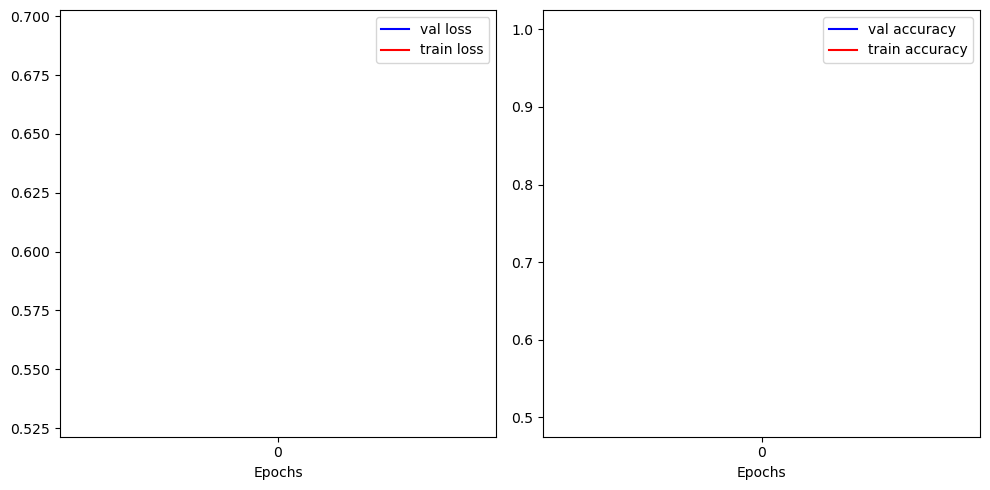

In [5]:
##########################
# plot loss and accuracy #

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))

ax1.plot([i for i in range(num_epochs)], mean_val_losses, c = 'b', label = 'val loss')
ax1.plot([i for i in range(num_epochs)], mean_train_losses, c = 'r', label = 'train loss')
ax1.set_xlabel("Epochs")
ax1.set_xticks(range(0,num_epochs+1,5))
ax1.legend()

ax2.plot([i for i in range(num_epochs)], mean_val_acc, c = 'b', label = 'val accuracy')
ax2.plot([i for i in range(num_epochs)], mean_train_acc, c = 'r', label = 'train accuracy')
ax2.set_xlabel("Epochs")
ax2.set_xticks(range(0,num_epochs+1,5))
ax2.legend()

plt.tight_layout()
plt.show()

# wandb.log({'model_performance': wandb.Image(fig)})

In [ ]:
####################
# generating CAMs #

#change batch size to 1 to grab one image at a time
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, 
                                          shuffle=True,
                                          num_workers=1)

# Load best model to produce CAMs with
model.load_state_dict(best_model)
model.eval()

# Save 10 palsa images
palsa_imgs = 0
for palsa_cam in range(100):
    im, lab = next(iter(valid_loader))

    #get the last convolution
    sf = SaveFeatures(model.features[-4])
    model.eval()

    if lab == 1:
        palsa_imgs+= 1
        im = Variable(im).to(device)
        outputs = model(im).to(device)
        res = torch.argmax(outputs.data).cpu().detach().numpy()

        # generate CAM
        sf.remove()
        arr = sf.features.cpu().detach().numpy()
        arr1 = arr[0]
        ans_nopalsa = np.dot(np.rollaxis(arr1,0,3), [1,0])
        ans_palsa = np.dot(np.rollaxis(arr1,0,3), [0,1])

        if res==1:
            CAM = resize(ans_palsa, (im_size*2,im_size*2))
        else:
            CAM = resize(ans_nopalsa, (im_size*2,im_size*2))

        # Plot image with CAM
        cpu_img = im.squeeze().cpu().detach().permute(1,2,0).long().numpy()

        fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,7))

        ax1.imshow(cpu_img)
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.set_title('original image')

        ax2.imshow(cpu_img)
        ax2.imshow(CAM, alpha=.4, cmap='jet')
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.set_title('image with CAM')

        plt.tight_layout()
        # plt.show()

        wandb.log({'generated_CAM': fig})

    if palsa_imgs == 10:
        break


In [ ]:
wandb.finish()

### LOGGING FORGOTTEN CAMS FROM SAVED MODELS

In [ ]:
# to load model again: 

run = wandb.init(project= 'VGG_CAMs', id= 'v6ax9crk', resume = 'must')

In [ ]:

artifact = run.use_artifact('nadjaflechner/VGG_CAMs/model:v9', type='model')
artifact_dir = artifact.download()
state_dict = torch.load(f"{artifact_dir}/model.pth")
model.load_state_dict(state_dict)
